In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import RFECV, RFE


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import RandomOverSampler 


%matplotlib inline

# Read data and only keep needed class

In [2]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1587, 41)


In [3]:
user_tr = user[pd.notnull(user['Sale_MF'])]
print(user_tr.shape)

(951, 41)


In [4]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)


In [101]:
user_tr_X = user_tr.drop('Sale_CL', axis=1)

user_tr_Y = user_tr['Sale_CL']

(951, 35)


(array([ 662.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  289.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

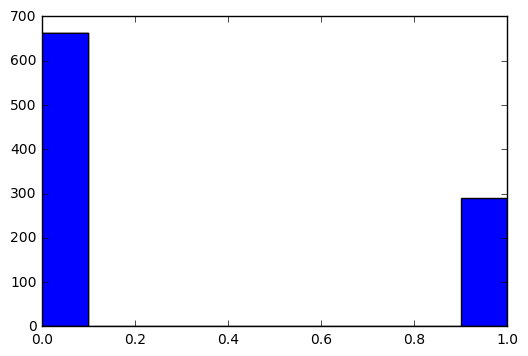

In [102]:
print(user_tr_X.shape)
plt.hist(user_tr_Y)

In [103]:

#missing data
total = user_tr_X.isnull().sum().sort_values(ascending=False)
percent = (user_tr_X.isnull().sum()/user_tr_X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
ActBal_CL_avg,0,0.0
Count_CL,0,0.0
ActBal_CL,0,0.0
ActBal_CC,0,0.0
ActBal_OVD,0,0.0
ActBal_MF,0,0.0
ActBal_SA,0,0.0
ActBal_CA,0,0.0
Count_CC,0,0.0
VolumeCred_CA,0,0.0


# Preprocessing of the data

## check for skewness and log transform if needed

In [104]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

In [105]:
user_tr_X.replace(np.NaN, 0, inplace=True)

## Remove outliers

In [106]:
for col in user_tr_X.columns:
    index = user_tr_X[np.abs(user_tr_X[col]-user_tr_X[col].mean())>(3*user_tr_X[col].std())].index.values
    user_tr_X.drop(index, inplace = True)
    user_tr_Y.drop(index, inplace = True)

## Upscaling

In [107]:
ros = RandomOverSampler(random_state=42)
user_tr_X, user_tr_Y = ros.fit_sample(user_tr_X,user_tr_Y)

# Test with basic data

In [112]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



TypeError: __init__() got an unexpected keyword argument 'normalize'

In [117]:
random_forest = RandomForestClassifier(n_estimators = 20)
scores = cross_val_score(random_forest, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.9465 (+/- 0.12)


In [110]:
gaussian = GaussianNB()
scores = cross_val_score(gaussian, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.60 (+/- 0.14)


# Scale the data

In [93]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
print(user_tr_X_scale)

[[  8.44055053e-01   5.80175955e-01   1.04478049e+00 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]
 [  1.08102690e+00   6.39481464e-01  -9.57138856e-01 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]
 [ -2.81561215e-01   4.31912183e-01   1.04478049e+00 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]
 ..., 
 [  1.06541476e-03   1.87007077e+00  -9.57138856e-01 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]
 [  3.10868400e-01   2.15177194e+00   1.04478049e+00 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]
 [ -4.45893690e-02   9.36009009e-01   1.04478049e+00 ...,  -4.80569331e-02
   -1.51081159e-01   0.00000000e+00]]


/home/nico/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [29]:
poly = PolynomialFeatures(degree=2)
user_tr_X_scale = poly.fit_transform(user_tr_X_scale)

In [94]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.65 (+/- 0.07)


In [59]:
logreg = LogisticRegression()
selector = RFECV(estimator=logreg, step=1, cv=5,scoring='roc_auc')

selector.fit(user_tr_X_scale, user_tr_Y)
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 24


In [60]:
user_tr_X_scale_transform = selector.transform(user_tr_X_scale)


In [27]:
poly = PolynomialFeatures(degree=2)
user_tr_X_scale_transform = poly.fit_transform(user_tr_X_scale_transform)

In [61]:
search = {'penalty': ['l1','l2'],'C': [0.001, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', None]}


logreg = LogisticRegression()

logreg_grid = GridSearchCV(estimator=logreg,param_grid=search, scoring='roc_auc', n_jobs=-1,refit=True, cv=10)
logreg_grid.fit(user_tr_X_scale_transform,user_tr_Y)
print(logreg_grid.best_estimator_)

print(logreg_grid.best_params_)

print(logreg_grid.best_score_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.699817310044


In [75]:
svc = SVC(kernel='rbf', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

roc_auc: 0.74 (+/- 0.11)
[ 0.66718646  0.64713745  0.74081726  0.76262626  0.7456382   0.85169881
  0.74655647  0.77433425  0.74747475  0.73117539]


search = search_dict = {'kernel': ['linear','rbf'],'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}


svc = SVC()

svc_grid = RandomizedSearchCV(estimator=svc,param_distributions=search, scoring='roc_auc', n_jobs=-1,refit=True, cv=3)
svc_grid.fit(user_tr_X_scale,user_tr_Y)
print(svc_grid.best_estimator_)

print(svc_grid.best_params_)

print(svc_grid.best_score_)

In [76]:
svc = SVC(kernel='linear', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



[ 0.60681666  0.62151927  0.74380165  0.69995409  0.71808999  0.75826446
  0.72359963  0.69788797  0.71602388  0.70385675]
roc_auc: 0.70 (+/- 0.09)


In [77]:
random_forest = RandomForestClassifier(n_estimators = 20)
scores = cross_val_score(random_forest, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.95 (+/- 0.12)


In [78]:
gaussian = GaussianNB()
scores = cross_val_score(gaussian, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.60 (+/- 0.06)


# PCA of the data

In [95]:
#dimension reduction
pca = PCA(n_components=10)
X_pca_20 = pca.fit_transform(user_tr_X_scale)
X_pca_20.shape

(868, 10)

In [168]:
svc = SVC(kernel='linear', degree=2, random_state=101)
scores = cross_val_score(svc, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.51518271  0.56562017  0.62643678  0.45977011  0.48850575  0.5799373
  0.54075235  0.52507837  0.44409613  0.47997835]
roc_auc: 0.52 (+/- 0.11)


In [279]:
#with penalty
logreg = LogisticRegression(penalty='l2', C=1)
scores = cross_val_score(logreg, X_pca_20, user_tr_Y, cv=20, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.43921569  0.54705882  0.54343434  0.53131313  0.65252525  0.62626263
  0.48686869  0.41818182  0.43434343  0.65151515  0.47402597  0.47186147
  0.50865801  0.60822511  0.51948052  0.51948052  0.51515152  0.495671
  0.67316017  0.41341991]
roc_auc: 0.53 (+/- 0.15)


In [96]:
random_forest = RandomForestClassifier(n_estimators = 50)
scores = cross_val_score(random_forest, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.95 (+/- 0.11)


In [171]:
svc_lin = LinearSVC()
scores = cross_val_score(svc_lin, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.50025733  0.47400926  0.63740857  0.61755486  0.57523511  0.59247649
  0.53605016  0.58881923  0.52298851  0.53733766]
roc_auc: 0.56 (+/- 0.10)


In [172]:
gaussian = GaussianNB()
scores = cross_val_score(gaussian, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.54 (+/- 0.09)


In [173]:
search = {'penalty': ['l1','l2'],'C': [0.001, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', None]}


logreg = LogisticRegression()

logreg_grid = GridSearchCV(estimator=logreg,param_grid=search, scoring='roc_auc', n_jobs=-1,refit=True, cv=10)
logreg_grid.fit(X_pca_20,user_tr_Y)
print(logreg_grid.best_estimator_)

print(logreg_grid.best_params_)

print(logreg_grid.best_score_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l1', 'class_weight': None, 'C': 10}
0.558789832821


# Check feature importance

In [305]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [306]:
# Finally let's run our Selection Stability method with Randomized Lasso
logreg = LogisticRegression()
logreg.fit(user_tr_X, user_tr_Y)
ranks["rlasso/Stability"] = ranking(np.abs(logreg.coef_[0]), colnames)
print('finished')

finished


In [307]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(user_tr_X, user_tr_Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


building tree 42 of 50building tree 43 of 50
building tree 44 of 50
building tree 45 of 50

building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


In [308]:
# Construct our Linear Regression model
lr = LogisticRegression()
lr.fit(user_tr_X, user_tr_Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(user_tr_X, user_tr_Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 666 features.
Fitting estimator with 665 features.
Fitting estimator with 664 features.
Fitting estimator with 663 features.
Fitting estimator with 662 features.
Fitting estimator with 661 features.
Fitting estimator with 660 features.
Fitting estimator with 659 features.
Fitting estimator with 658 features.
Fitting estimator with 657 features.
Fitting estimator with 656 features.
Fitting estimator with 655 features.
Fitting estimator with 654 features.
Fitting estimator with 653 features.
Fitting estimator with 652 features.
Fitting estimator with 651 features.
Fitting estimator with 650 features.
Fitting estimator with 649 features.
Fitting estimator with 648 features.
Fitting estimator with 647 features.
Fitting estimator with 646 features.
Fitting estimator with 645 features.
Fitting estimator with 644 features.
Fitting estimator with 643 features.
Fitting estimator with 642 features.
Fitting estimator with 641 features.
Fitting estimator with 640 features.
F

In [309]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	RF	RFE	rlasso/Stability	Mean
Age	0.0	0.1	0.0	0.03
Tenure	0.66	0.35	0.0	0.34
M	1.0	0.37	0.0	0.46
Count_CA	0.03	0.08	0.0	0.04
Count_SA	0.08	0.11	0.0	0.06
Count_MF	0.04	0.05	0.0	0.03
Count_OVD	0.04	0.05	0.0	0.03
Count_CC	0.0	0.06	0.0	0.02
Count_CL	0.01	0.04	0.0	0.02
ActBal_CA	0.0	0.02	0.0	0.01
ActBal_SA	0.28	0.74	0.01	0.34
ActBal_MF	0.05	0.52	0.0	0.19
ActBal_OVD	0.04	0.55	0.0	0.2
ActBal_CC	0.02	0.28	0.0	0.1
ActBal_CL	0.04	0.34	0.0	0.13
VolumeCred	0.01	0.35	0.0	0.12
VolumeCred_CA	0.34	0.6	0.0	0.31
TransactionsCred	0.32	0.59	0.0	0.3
TransactionsCred_CA	0.14	0.18	0.0	0.11
VolumeDeb	0.17	0.15	0.0	0.11
VolumeDeb_CA	0.26	0.59	0.0	0.28
VolumeDebCash_Card	0.22	0.57	0.0	0.26
VolumeDebCashless_Card	0.12	0.42	0.0	0.18
VolumeDeb_PaymentOrder	0.14	0.4	0.0	0.18
TransactionsDeb	0.12	0.49	0.0	0.2
TransactionsDeb_CA	0.15	0.24	0.0	0.13
TransactionsDebCash_Card	0.26	0.22	0.0	0.16
TransactionsDebCashless_Card	0.15	0.11	0.0	0.09
TransactionsDeb_PaymentOrder	0.1	0.18	0.0	0.09
Actbal_CA_avg	0.11	0.17	0.0	0.09


In [310]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

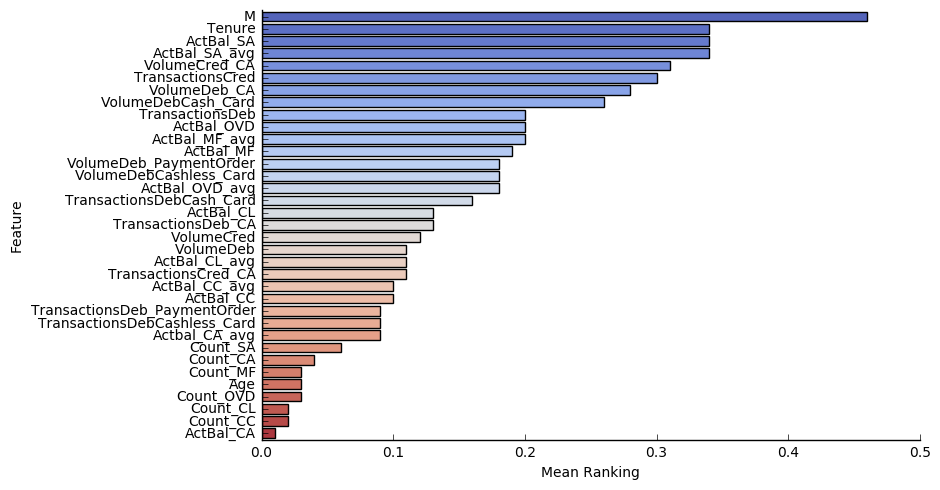

In [311]:
#Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=5, aspect=1.9, palette='coolwarm')

In [188]:
user_tr_X = user_tr.drop(['Sale_CL'], axis=1)

In [189]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.6703 (+/- 0.11)


In [190]:
random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.5573 (+/- 0.13)


In [191]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)

In [192]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.6762 (+/- 0.11)
